#**Objective:**

Consider the QWorld environment. The objective of this code is to design a agent that learn how to solve this problem through the **sarsamax (Q-learning)** and **sarsa** algorithms respectively in **PART1** and **PART2**

In [ ]:
"""Q Learning to solve a simple world model

Simple deterministic MDP is made of 6 grids (states)
---------------------------------
|         |          |          |
|  Start  |          |  Goal    |
|         |          |          |
---------------------------------
|         |          |          |
|         |          |  Hole    |
|         |          |          |
---------------------------------

"""

from collections import deque
import numpy as np
import argparse
import os
import time
from termcolor import colored


class QWorld:
    def __init__(self):
        """Simulated deterministic world made of 6 states.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = 4

        # 6 states
        self.row = 6

        # setup the environment
        self.init_transition_table()
        self.init_reward_table()

        # reset the environment
        self.reset()

    def reset(self):
        """start of episode"""
        self.state = 0
        self.count = 0
        return self.state

    def is_in_win_state(self):
        """agent wins when the goal is reached"""
        return self.state == 2


    def init_reward_table(self):
        """
        0 - Left, 1 - Down, 2 - Right, 3 - Up
        ----------------
        | 0 | 0 | 100  |
        ----------------
        | 0 | 0 | -100 |
        ----------------
        """
        self.reward_table = np.zeros([self.row, self.col])
        self.reward_table[1, 2] = 100.
        self.reward_table[4, 2] = -100.


    def init_transition_table(self):
        """
        0 - Left, 1 - Down, 2 - Right, 3 - Up
        -------------
        | 0 | 1 | 2 |
        -------------
        | 3 | 4 | 5 |
        -------------
        """
        self.transition_table = np.zeros([self.row, self.col],
                                         dtype=int)

        self.transition_table[0, 0] = 0
        self.transition_table[0, 1] = 3
        self.transition_table[0, 2] = 1
        self.transition_table[0, 3] = 0

        self.transition_table[1, 0] = 0
        self.transition_table[1, 1] = 4
        self.transition_table[1, 2] = 2
        self.transition_table[1, 3] = 1

        # terminal Goal state
        self.transition_table[2, 0] = 2
        self.transition_table[2, 1] = 2
        self.transition_table[2, 2] = 2
        self.transition_table[2, 3] = 2

        self.transition_table[3, 0] = 3
        self.transition_table[3, 1] = 3
        self.transition_table[3, 2] = 4
        self.transition_table[3, 3] = 0

        self.transition_table[4, 0] = 3
        self.transition_table[4, 1] = 4
        self.transition_table[4, 2] = 5
        self.transition_table[4, 3] = 1

        # terminal Hole state
        self.transition_table[5, 0] = 5
        self.transition_table[5, 1] = 5
        self.transition_table[5, 2] = 5
        self.transition_table[5, 3] = 5


    def step(self, action):
        """execute the action on the environment
        Argument:
            action (tensor): An action in Action space
        Returns:
            next_state (tensor): next env state
            reward (float): reward received by the agent
            done (Bool): whether the terminal state
                is reached
        """
        # determine the next_state given state and action
        next_state = self.transition_table[self.state, action]
        # done is True if next_state is Goal or Hole
        done = next_state == 2 or next_state == 5
        # reward given the state and action
        reward = self.reward_table[self.state, action]
        # the enviroment is now in new state
        self.state = next_state
        self.count+=1
        return next_state, reward, done




    def print_cell(self, row=0):
        """UI to display agent moving on the grid"""
        print("")
        for i in range(13):
            j = i - 2
            if j in [0, 4, 8]:
                if j == 8:
                    if self.state == 2 and row == 0:
                        marker = "\033[4mG\033[0m"
                    elif self.state == 5 and row == 1:
                        marker = "\033[4mH\033[0m"
                    else:
                        marker = 'G' if row == 0 else 'H'
                    color = self.state == 2 and row == 0
                    color = color or (self.state == 5 and row == 1)
                    color = 'red' if color else 'blue'
                    print(colored(marker, color), end='')
                elif self.state in [0, 1, 3, 4]:
                    cell = [(0, 0, 0), (1, 0, 4), (3, 1, 0), (4, 1, 4)]
                    marker = '_' if (self.state, row, j) in cell else ' '
                    print(colored(marker, 'red'), end='')
                else:
                    print(' ', end='')
            elif i % 4 == 0:
                    print('|', end='')
            else:
                print(' ', end='')
        print("")


    def print_world(self, action, step,is_explore):
        """UI to display mode and action of agent"""
        actions = { 0: "(Left)", 1: "(Down)", 2: "(Right)", 3: "(Up)" }
        explore = "Explore" if is_explore else "Exploit"
        print("Step", step, ":", explore, actions[action])
        for _ in range(13):
            print('-', end='')
        self.print_cell()
        for _ in range(13):
            print('-', end='')
        self.print_cell(row=1)
        for _ in range(13):
            print('-', end='')
        print("")




In [ ]:
def print_episode(episode, delay=1):
    """UI to display episode count
    Arguments:
        episode (int): episode number
        delay (int): sec delay

    """
    os.system('clear')
    for _ in range(13):
        print('=', end='')
    print("")
    print("Episode ", episode)
    for _ in range(13):
        print('=', end='')
    print("")
    time.sleep(delay)


def print_status(q_world,q_agent, done, step, delay=1):
    """UI to display the world,
        delay of 1 sec for ease of understanding
    """
    os.system('clear')
    q_world.print_world(action, step,q_agent.is_explore)
    q_agent.print_q_table()
    if done:
        print("-------EPISODE DONE--------")
        delay *= 2
    time.sleep(delay)

# **PART1**: SARSAMAX agent (off-policy)


## design an agent that learns through Q-learning
Recall the steps :
1. Start with an empty table for $Q(s, a)$.
2. Obtain $(s, a, r, s')$ from the environment.
3. Make a Bellman update: $𝑄(𝑠, 𝑎) ← (1 − 𝛼)𝑄(𝑠, 𝑎) + 𝛼 (𝑟 + 𝛾\max\limits_{x'\in A} Q(s',a'))$
4. Check convergence conditions. If not met, repeat from step 2.

In [ ]:
class QAgent:
    def __init__(self, col, row, alpha):
        """Q-Learning based agent by Bellman Equation.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = col

        # 6 states
        self.row = row

        # initialize the q table
        self.q_table = np.zeros([self.row, self.col])

        # discount factor
        self.gamma = 0.9

        # learning rate
        self.alpha = alpha

        # 90% exploration, 10% exploitation
        self.epsilon = 0.9
        # exploration decays by this factor every episode
        self.epsilon_decay = 0.9
        # in the long run, 10% exploration, 90% exploitation
        self.epsilon_min = 0

        # set action model to exploration
        self.is_explore = True

    def act(self, state):
        """determine the next action
            either for Q Table(exploitation) or
            random(exploration)
        Return:
            action (tensor): action that the agent
                must execute
        """
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        # action based on exploration
        if np.random.rand() < self.epsilon:
            self.is_explore = True
            action = np.random.choice(range(4))

        else:
            self.is_explore = False
            action = np.argmax(self.q_table[state])

        return action

    def update_q_table(self, state, action, reward, next_state):
      """Q-Learning - update the Q Table using Q(s, a)
        Arguments:
            state (tensor) : agent state
            action (tensor): action executed by the agent
            reward (float): reward after executing action
                for a given state
            next_state (tensor): next state after executing
                action for a given state
        """
      current_q_value = self.q_table[state, action]
      next_max_q_value = np.max(self.q_table[next_state])
      new_q_value = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * next_max_q_value)
      self.q_table[state, action] = new_q_value




    def print_q_table(self):
        """UI to dump Q Table contents"""
        print("Q-Table (Epsilon: %0.2f)" % self.epsilon)
        print(self.q_table)

    def update_epsilon(self):
        """update Exploration-Exploitation mix"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


#Implement a training loop

In [ ]:
delay = 0
wins = 0
episode_count = 10000

# Lists to store data for plotting
iteration_list = []
percent_wins_list = []



q_world = QWorld()

q_agent = QAgent(col=q_world.col, row=q_world.row, alpha=0.1)

#count the number of iterations
iterations = 0

np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)
    while not done:
      # todo: Obtain  next_state, reward, done  from the environment.
        action = q_agent.act(state)
        next_state, reward, done = q_world.step(action)

        # todo: update the q-table.
        q_agent.update_q_table(state, action, reward, next_state)

        # todo: update state: the current state becomes the next_state in the next iteration

        state = next_state

        iterations += 1


        if done:
            if q_world.is_in_win_state():
                wins += 1

    percent_wins = 100.0 * wins / (episode + 1)
    print("------- %0.2f%% Goals in %d Episodes  ---------"
                  % (percent_wins, episode))

    q_agent.update_epsilon()
    iteration_list.append(iterations)
    percent_wins_list.append(percent_wins)



    if (episode > 100) & (percent_wins >= 99.5):
        print("solved in %d iterations" % iterations)
        break

Episode  0
------- 0.00% Goals in 0 Episodes  ---------
Episode  1
------- 0.00% Goals in 1 Episodes  ---------
Episode  2
------- 33.33% Goals in 2 Episodes  ---------
Episode  3
------- 50.00% Goals in 3 Episodes  ---------
Episode  4
------- 60.00% Goals in 4 Episodes  ---------
Episode  5
------- 66.67% Goals in 5 Episodes  ---------
Episode  6
------- 71.43% Goals in 6 Episodes  ---------
Episode  7
------- 75.00% Goals in 7 Episodes  ---------
Episode  8
------- 77.78% Goals in 8 Episodes  ---------
Episode  9
------- 80.00% Goals in 9 Episodes  ---------
Episode  10
------- 81.82% Goals in 10 Episodes  ---------
Episode  11
------- 75.00% Goals in 11 Episodes  ---------
Episode  12
------- 76.92% Goals in 12 Episodes  ---------
Episode  13
------- 78.57% Goals in 13 Episodes  ---------
Episode  14
------- 80.00% Goals in 14 Episodes  ---------
Episode  15
------- 81.25% Goals in 15 Episodes  ---------
Episode  16
------- 82.35% Goals in 16 Episodes  ---------
Episode  17
-------

#**SOME (Q/A)'s**
# Based on the the cell above, when is the problem considered solved? And, after how many iterations the problem was actually solved?
**ANSWER :**
the problem considered as solved when : (episode>100) & (percent_wins>=99.5) ,
the problem in our situation was solved in 1289 iterations where exactly the percent wins become greater then 99.5%

# Provide a plot of the percent_wins as a function of the iterations

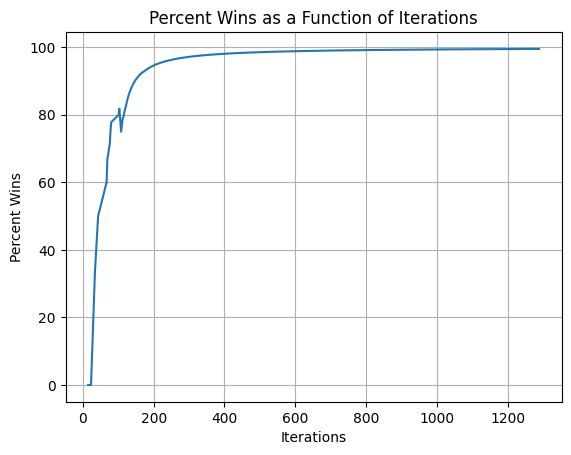

In [ ]:
import matplotlib.pyplot as plt
plt.plot(iteration_list, percent_wins_list)
plt.xlabel('Iterations')
plt.ylabel('Percent Wins')
plt.title('Percent Wins as a Function of Iterations')
plt.grid(True)
plt.show()

# Print the final Q-table (after training loop ends)

In [ ]:
q_agent.print_q_table()

Q-Table (Epsilon: 0.00)
[[  0.600777   0.        90.         0.      ]
 [  0.600777   2.543372 100.        16.139919]
 [  0.         0.         0.         0.      ]
 [  0.         0.         0.351459   0.      ]
 [  0.         0.351459 -27.1       21.025688]
 [  0.         0.         0.         0.      ]]


#Based on this final table, what is the best action to take if the agent is in state 3 ?
**Answer :** in the state 3 the reward actions are [0,0,0.351459,0] so the best action is the 3rd case which correspend to the action 2 which is right action

#Using the trained agent in 5 episodes-- full exploitation

In [ ]:
q_agent.epsilon=0
episode_list = []
goal_reached_list = []

# Run 5 episodes with full exploitation
for episode in range(5):
    state = q_world.reset()
    done = False
    goal_reached = False
    step=0
    print_status(q_world,q_agent, done, step, delay=1)
    step=1
    while not done:
        action = q_agent.act(state)
        next_state, _, done = q_world.step(action)
        if q_world.is_in_win_state():
            goal_reached = True

        state = next_state
        print_status(q_world,q_agent, done, step, delay=1)
        step+=1

    episode_list.append(episode+1)
    goal_reached_list.append(1 if goal_reached else 0)

Step 0 : Exploit (Right)
-------------
| _ |   | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  0.600777   0.        90.         0.      ]
 [  0.600777   2.543372 100.        16.139919]
 [  0.         0.         0.         0.      ]
 [  0.         0.         0.351459   0.      ]
 [  0.         0.351459 -27.1       21.025688]
 [  0.         0.         0.         0.      ]]
Step 1 : Exploit (Right)
-------------
|   | _ | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  0.600777   0.        90.         0.      ]
 [  0.600777   2.543372 100.        16.139919]
 [  0.         0.         0.         0.      ]
 [  0.         0.         0.351459   0.      ]
 [  0.         0.351459 -27.1       21.025688]
 [  0.         0.         0.         0.      ]]
Step 2 : Exploit (Right)
-------------
|   |   | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  0.600777   0.        90.         0.      ]
 [  0.600777   2.543372 100.  

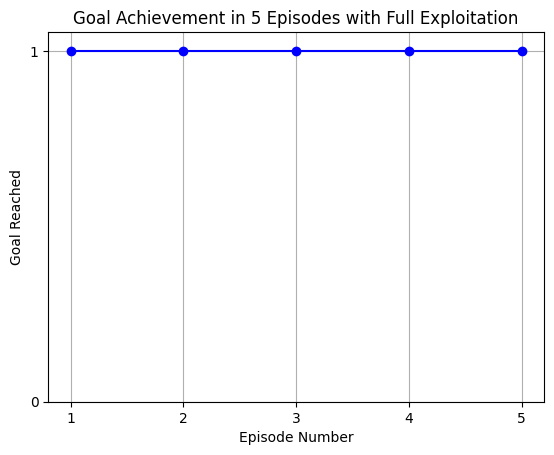

Percent Wins for 5 Episodes: 100.00%


In [ ]:
# Plotting
plt.plot(episode_list, goal_reached_list, marker='o', linestyle='-', color='b')
plt.xlabel('Episode Number')
plt.ylabel('Goal Reached')
plt.title('Goal Achievement in 5 Episodes with Full Exploitation')
plt.xticks(range(min(episode_list), max(episode_list) + 1))
plt.yticks([0, 1])
plt.grid(True)
plt.show()

# Calculate percent wins for these 5 episodes (full exploitation)
percent_wins_5_episodes = sum(goal_reached_list) / len(goal_reached_list) * 100
print("Percent Wins for 5 Episodes: %0.2f%%" % percent_wins_5_episodes)

#**Comments**
#We see that q_table is remainly unchainged because we are in full exploitation mode

# **PART2**: SARSA-based agent (ON-policy)
Recall the steps :
1. Start with an empty table for $Q(s, a)$.
2. Obtain $(s, a, r, s')$ from the environment.
3. Make a Bellman update: $𝑄(𝑠, 𝑎) ← (1 − 𝛼)𝑄(𝑠, 𝑎) + 𝛼 (𝑟 + 𝛾\max\limits_{x'\in A} Q(s',a'))$
4. Check convergence conditions. If not met, repeat from step 2.

In [ ]:
class QAgent_Onpolicy:
    def __init__(self, col, row, alpha):
        """Q-Learning based agent by Bellman Equation.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = col

        # 6 states
        self.row = row

        # initialize the q table
        self.q_table = np.zeros([self.row, self.col])

        # discount factor
        self.gamma = 0.9

        # learning rate
        self.alpha = alpha

        # 90% exploration, 10% exploitation
        self.epsilon = 0.9
        # exploration decays by this factor every episode
        self.epsilon_decay = 0.9
        # in the long run, 10% exploration, 90% exploitation
        self.epsilon_min = 0

        # set action model to exploration
        self.is_explore = True

    def act(self, state):
        """determine the next action
            either for Q Table(exploitation) or
            random(exploration)
        Return:
            action (tensor): action that the agent
                must execute
        """
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        # action based on exploration
        if np.random.rand() <= self.epsilon:
            self.is_explore = True
            action = np.random.choice(range(4))

        else:
            self.is_explore = False
            action = np.argmax(self.q_table[state])

        return action

    #the change is in the update_qtable function
    def update_q_table(self, state, action, reward, next_state, next_action):
        current_value = self.q_table[state, action]
        next_value = self.q_table[next_state, next_action]
        target = reward + self.gamma * next_value
        new_value = current_value + self.alpha * (target - current_value)
        self.q_table[state, action] = new_value


    def print_q_table(self):
        """UI to dump Q Table contents"""
        print("Q-Table (Epsilon: %0.2f)" % self.epsilon)
        print(self.q_table)

    def update_epsilon(self):
        """update Exploration-Exploitation mix"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


#implement a training loop



In [ ]:
delay = 0
wins = 0
episode_count = 10000

# Lists to store data for plotting
iteration_list = []
percent_wins_list = []
q_world = QWorld()
q_agent = QAgent_Onpolicy(col=q_world.col, row=q_world.row, alpha=0.1)

#count the number of iterations
iterations = 0

np.random.seed(5)
for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)
    action = q_agent.act(state)
    while not done:
        next_state, reward, done = q_world.step(action)
        next_action=q_agent.act(next_state)
        q_agent.update_q_table(state, action, reward, next_state,next_action)
        state = next_state
        action=next_action
        iterations += 1


        if done:
            if q_world.is_in_win_state():
                wins += 1

    percent_wins = 100.0 * wins / (episode + 1)
    print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))

    q_agent.update_epsilon()
    iteration_list.append(iterations)
    percent_wins_list.append(percent_wins)
    if (episode > 100) & (percent_wins >= 99.5):
        print("solved in %d iterations" % iterations)
        break

Episode  0
-------0.00% Goals in 0 Episodes---------
Episode  1
-------0.00% Goals in 1 Episodes---------
Episode  2
-------33.33% Goals in 2 Episodes---------
Episode  3
-------50.00% Goals in 3 Episodes---------
Episode  4
-------60.00% Goals in 4 Episodes---------
Episode  5
-------66.67% Goals in 5 Episodes---------
Episode  6
-------71.43% Goals in 6 Episodes---------
Episode  7
-------75.00% Goals in 7 Episodes---------
Episode  8
-------77.78% Goals in 8 Episodes---------
Episode  9
-------80.00% Goals in 9 Episodes---------
Episode  10
-------81.82% Goals in 10 Episodes---------
Episode  11
-------83.33% Goals in 11 Episodes---------
Episode  12
-------84.62% Goals in 12 Episodes---------
Episode  13
-------85.71% Goals in 13 Episodes---------
Episode  14
-------86.67% Goals in 14 Episodes---------
Episode  15
-------87.50% Goals in 15 Episodes---------
Episode  16
-------88.24% Goals in 16 Episodes---------
Episode  17
-------88.89% Goals in 17 Episodes---------
Episode  18
--

#after 399 episodes (where accuaracy reached over 99.5% ) and the problem considered as solved after 884 iterations

#Provide a plot of the percent_wins as a function of the iterations

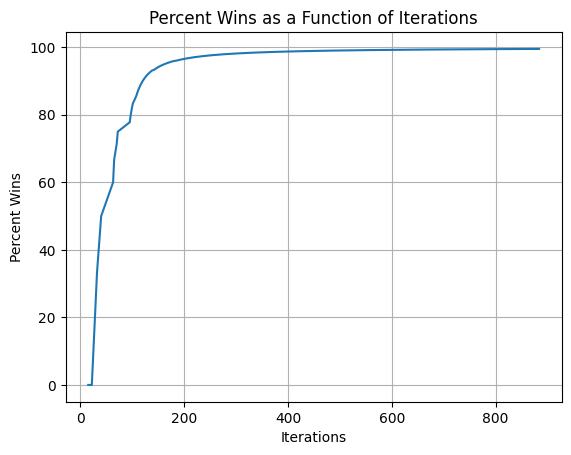

In [ ]:
import matplotlib.pyplot as plt
plt.plot(iteration_list, percent_wins_list)
plt.xlabel('Iterations')
plt.ylabel('Percent Wins')
plt.title('Percent Wins as a Function of Iterations')
plt.grid(True)
plt.show()

#Print the final Q-table (after training loop ends)

In [ ]:
q_agent.print_q_table()

Q-Table (Epsilon: 0.00)
[[ 3.222180e-01  5.384095e-02  9.000000e+01  0.000000e+00]
 [ 0.000000e+00  1.247600e-01  1.000000e+02  6.175705e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  2.076982e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00 -1.900000e+01  2.497820e+01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]]


#**(Q/A)**
#Based on this final table, what is the best action to take if the agent is in state 3?
**Answer :** in the state 3 the reward actions are [0,0,0,2.076982] so best action to take is "right"

#now using the trained agent in 5 episodes-- full exploitation

In [ ]:
q_agent.epsilon=0
episode_list = []
goal_reached_list = []

# Run 5 episodes with full exploitation
for episode in range(5):
    state = q_world.reset()
    done = False
    goal_reached = False
    step=0
    print_status(q_world,q_agent, done, step, delay=1)
    step=1
    while not done:
        action = q_agent.act(state)
        next_state, _, done = q_world.step(action)
        next_action=q_agent.act(next_state)
        if q_world.is_in_win_state():
            goal_reached = True

        state = next_state
        print_status(q_world,q_agent, done, step, delay=1)
        action=next_action
        step+=1

    episode_list.append(episode+1)
    goal_reached_list.append(1 if goal_reached else 0)

Step 0 : Exploit (Left)
-------------
| _ |   | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[ 3.222180e-01  5.384095e-02  9.000000e+01  0.000000e+00]
 [ 0.000000e+00  1.247600e-01  1.000000e+02  6.175705e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  2.076982e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00 -1.900000e+01  2.497820e+01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]]
Step 1 : Exploit (Right)
-------------
|   | _ | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[ 3.222180e-01  5.384095e-02  9.000000e+01  0.000000e+00]
 [ 0.000000e+00  1.247600e-01  1.000000e+02  6.175705e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  2.076982e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00 -1.900000e+01  2.497820e+01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]]
Step 2 : Exploit (Right)
-------------
|   |   | G |


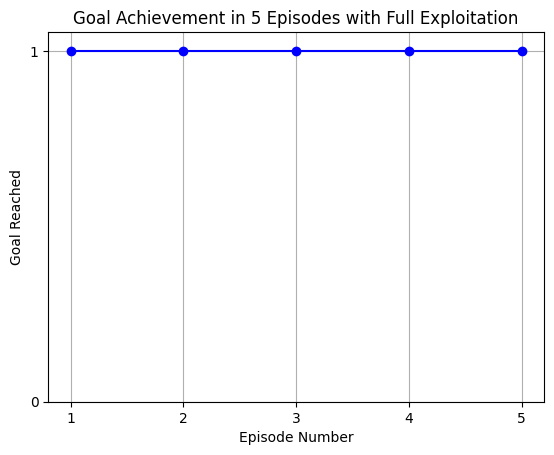

Percent Wins for 5 Episodes: 100.00%


In [ ]:
# Plotting
plt.plot(episode_list, goal_reached_list, marker='o', linestyle='-', color='b')
plt.xlabel('Episode Number')
plt.ylabel('Goal Reached')
plt.title('Goal Achievement in 5 Episodes with Full Exploitation')
plt.xticks(range(min(episode_list), max(episode_list) + 1))
plt.yticks([0, 1])
plt.grid(True)
plt.show()

# Calculate percent wins for these 5 episodes (full exploitation)
percent_wins_5_episodes = sum(goal_reached_list) / len(goal_reached_list) * 100
print("Percent Wins for 5 Episodes: %0.2f%%" % percent_wins_5_episodes)